In [ ]:

import os, sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Utilities import (prefer your consolidated helpers) ----------
def _import_utils():
    import test_gpt as utils
    return utils, "test_gpt"


def _to_np(x):
    return x.values if hasattr(x, "values") else np.asarray(x)

def _mid_dict(schema):
    return {v.name: 0.5*(float(v.low)+float(v.high)) for v in schema.continuous}

def _grid2d(schema, var_x, var_y, n=120, fixed=None):
    if fixed is None: fixed = {}
    vx = next(v for v in schema.continuous if v.name == var_x)
    vy = next(v for v in schema.continuous if v.name == var_y)
    xs = np.linspace(vx.low, vx.high, n)
    ys = np.linspace(vy.low, vy.high, n)
    base = _mid_dict(schema)
    base.update({k: float(v) for k,v in (fixed or {}).items()})
    rows = []
    for y in ys:
        for x in xs:
            r = dict(base)
            r[var_x] = float(x); r[var_y] = float(y)
            rows.append(r)
    return pd.DataFrame(rows), xs, ys

# ---------- Build/read readouts ----------
def _build_base_priors(utils, schema, llm_model="gpt-4o-mini", cache_dir=None):
    cache_dir = Path(cache_dir or (Path.cwd()/ "cache"))
    cache_dir.mkdir(parents=True, exist_ok=True)
    try:
        llm_fn = utils.make_openai_llm_fn(model=llm_model, base_url=None)
    except Exception:
        llm_fn = None
    # Baselines
    no_prior  = utils.build_no_prior(schema)
    heuristic = utils.build_heuristic(schema)
    # LLM "good"
    try:
        good = utils.llm_readout(schema, utils.GOOD_BULLETS, llm_fn, cache_dir, tag="llm_good", model_name=llm_model)
    except TypeError:
        good = utils.llm_readout(schema, utils.GOOD_BULLETS, llm_fn, cache_dir/ "llm_good_readout.json")
    # LLM "bad" from adversarializing the good readout if available
    if hasattr(utils, "adversarialize_readout"):
        bad = utils.adversarialize_readout(good)
    else:
        bad = {"effects":{}, "interactions":[]}
        for v in schema.continuous:
            bad["effects"][v.name] = {"effect":"decrease","scale":0.8,"confidence":0.8}
        bad["meta"] = {"origin":"simple-bad"}
    return {"no_prior": no_prior, "heuristic": heuristic, "llm_good": good, "llm_bad": bad}, llm_fn

def _paraphrase_good_bullets(bullets):
    # Lightweight paraphrases to induce LLM variability when API is present
    return [
        [b.replace("higher","increased") for b in bullets],
        [b.replace("lower","reduced") for b in bullets],
        [b + " Avoid extremes." for b in bullets],
        [b.replace("improves","enhances") for b in bullets],
        bullets
    ]

def _build_variants(utils, schema, base_readout, kind, n_variants=6, llm_fn=None, cache_dir=None):
    """
    kind: 'good' or 'bad'
    If llm_fn is available (and kind == 'good'), generate variants via paraphrases.
    Else jitter numeric parameters of the base readout deterministically.
    """
    cache_dir = Path(cache_dir or (Path.cwd()/ "cache")); cache_dir.mkdir(parents=True, exist_ok=True)
    readouts = []
    if llm_fn is not None and kind == "good" and hasattr(utils, "llm_readout") and hasattr(utils, "GOOD_BULLETS"):
        variants = _paraphrase_good_bullets(utils.GOOD_BULLETS)[:n_variants]
        for i, vb in enumerate(variants):
            try:
                ro = utils.llm_readout(schema, vb, llm_fn, cache_dir, tag=f"good_var{i}", model_name="gpt-4o-mini")
            except TypeError:
                ro = utils.llm_readout(schema, vb, llm_fn, cache_dir / f"llm_good_var{i}.json")
            readouts.append(ro)
        if len(readouts) >= n_variants:
            return readouts[:n_variants]

    # Fallback: deterministic jitter
    rng = np.random.default_rng(13 if kind=="good" else 131)
    base = json.loads(json.dumps(base_readout))  # deep copy
    for i in range(n_variants):
        ro = json.loads(json.dumps(base))
        for var, eff in ro.get("effects", {}).items():
            if "scale" in eff:
                eff["scale"] = float(np.clip(eff["scale"] * (1.0 + rng.normal(0, 0.12)), 0.0, 1.0))
            if "confidence" in eff:
                eff["confidence"] = float(np.clip(eff["confidence"] * (1.0 + rng.normal(0, 0.10)), 0.0, 1.0))
            if "range_hint" in eff and isinstance(eff["range_hint"], (list, tuple)) and len(eff["range_hint"])==2:
                lo, hi = eff["range_hint"]
                center = 0.5*(lo+hi) + float(rng.normal(0, 0.03))
                width  = max(hi-lo, 0.05) * float(np.clip(1.0 + rng.normal(0, 0.15), 0.2, 1.8))
                lo = float(np.clip(center - width/2, 0.0, 1.0))
                hi = float(np.clip(center + width/2, 0.0, 1.0))
                if hi < lo: lo, hi = hi, lo
                eff["range_hint"] = [lo, hi]
            if rng.random() < 0.1:
                if eff.get("effect") == "increase":
                    eff["effect"] = "increase-saturating"
                elif eff.get("effect") == "decrease":
                    eff["effect"] = "increase"
        readouts.append(ro)
    return readouts[:n_variants]

# ---------- B1: Variance heatmap + histogram ----------
def make_prompt_sensitivity_variance(
    data_csv,
    out_dir="agnp_prompt_sensitivity",
    var_pair=("QAgNO3(%)","Qseed(%)"),
    n_grid=140,
    fixed=None,
    n_variants=6,
    llm_model="gpt-4o-mini",
    show=True,
    return_figs=True
):
    """
    Builds variants of GOOD (and BAD) priors and plots the pointwise variance of prior_score
    over a 2D slice. Also produces a histogram of the variance distribution.
    Returns: dict with paths and figure handles.
    """
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    utils, used = _import_utils()
    schema, _ = utils.derive_schema(str(data_csv))
    fixed = dict(fixed or {})

    pri, llm_fn = _build_base_priors(utils, schema, llm_model=llm_model, cache_dir=out_dir/"cache")
    good_vars = _build_variants(utils, schema, pri["llm_good"], "good", n_variants=n_variants, llm_fn=llm_fn, cache_dir=out_dir/"cache")
    if hasattr(utils, "adversarialize_readout"):
        bad_base = utils.adversarialize_readout(pri["llm_good"])
    else:
        bad_base = pri["llm_bad"]
    bad_vars  = _build_variants(utils, schema, bad_base, "bad",  n_variants=n_variants, llm_fn=None, cache_dir=out_dir/"cache")

    vx, vy = var_pair
    grid, xs, ys = _grid2d(schema, vx, vy, n=n_grid, fixed=fixed)

    # Compute S matrices (#variants, N)
    def _stack_scores(readouts):
        rows = []
        for ro in readouts:
            s = _to_np(utils.prior_score_df(schema, ro, grid))
            rows.append(s)
        return np.vstack(rows) if rows else np.zeros((0, len(grid)))
    Sg = _stack_scores(good_vars)
    Sb = _stack_scores(bad_vars)

    # Pointwise variance
    var_g = np.var(Sg, axis=0).reshape(n_grid, n_grid) if Sg.size else np.zeros((n_grid,n_grid))
    var_b = np.var(Sb, axis=0).reshape(n_grid, n_grid) if Sb.size else np.zeros((n_grid,n_grid))

    # --- Heatmaps ---
    def _heat(figtitle, V, tag):
        fig, ax = plt.subplots(figsize=(6,5))
        im = ax.imshow(V, origin="lower", aspect="auto",
                       extent=[xs.min(), xs.max(), ys.min(), ys.max()])
        ax.set_xlabel(vx); ax.set_ylabel(vy)
        ax.set_title(figtitle)
        cbar = fig.colorbar(im, ax=ax); cbar.set_label("variance of prior_score")
        fig.tight_layout()
        p = out_dir / f"variance_heatmap_{tag}_{vx.replace('%','pct')}_vs_{vy.replace('%','pct')}.png"
        fig.savefig(p, dpi=170, bbox_inches="tight")
        if show:
            try:
                from IPython.display import display; display(fig)
            except Exception:
                pass
        return fig, str(p)

    fig_g, path_g = _heat(f"Prompt-sensitivity (GOOD variants): var(prior_score) — {vx} vs {vy}", var_g, "good")
    fig_b, path_b = _heat(f"Prompt-sensitivity (BAD variants): var(prior_score) — {vx} vs {vy}", var_b, "bad")

    # --- Histograms ---
    def _hist(V, tag, title):
        fig, ax = plt.subplots(figsize=(5.4,3.4))
        ax.hist(V.ravel(), bins=40)
        ax.set_xlabel("variance of prior_score"); ax.set_ylabel("count")
        ax.set_title(title); fig.tight_layout()
        p = out_dir / f"variance_hist_{tag}_{vx.replace('%','pct')}_vs_{vy.replace('%','pct')}.png"
        fig.savefig(p, dpi=170, bbox_inches="tight")
        return fig, str(p)

    fh_g, ph_g = _hist(var_g, "good", "Distribution of variance (GOOD variants)")
    fh_b, ph_b = _hist(var_b, "bad",  "Distribution of variance (BAD variants)")

    return {
        "paths": [path_g, path_b, ph_g, ph_b],
        "figs": {
            "heat_good": fig_g, "heat_bad": fig_b,
            "hist_good": fh_g,  "hist_bad": fh_b
        } if return_figs else {}
    }

# ---------- B2: Readout embedding & PCA ----------
def _readout_to_vec(schema, ro):
    # For each variable: one-hot of effect (6) + scale + conf + range_center + range_width = 10 dims
    eff_order = ["increase","decrease","increase-saturating","nonmonotone-peak","nonmonotone-valley","flat"]
    v = []
    for var in [c.name for c in schema.continuous]:
        e = (ro.get("effects",{}) or {}).get(var, {})
        onehot = [1.0 if e.get("effect") == k else 0.0 for k in eff_order]
        scale = float(e.get("scale", 0.0))
        conf  = float(e.get("confidence", 0.0))
        rh = e.get("range_hint", None)
        if isinstance(rh, (list,tuple)) and len(rh)==2:
            lo,hi = float(rh[0]), float(rh[1])
            center = 0.5*(lo+hi); width = max(hi-lo, 0.0)
        else:
            center = 0.0; width = 0.0
        v.extend(onehot + [scale, conf, center, width])
    # Add interaction counts
    inters = ro.get("interactions") or []
    syn = sum(1 for it in inters if it.get("type")=="synergy")
    ant = sum(1 for it in inters if it.get("type")=="antagonism")
    v.extend([float(syn), float(ant)])
    return np.array(v, dtype=float)

def make_readout_embedding_pca(
    data_csv,
    out_dir="agnp_prompt_sensitivity",
    n_variants=8,
    llm_model="gpt-4o-mini",
    show=True,
    return_fig=True
):
    """
    Builds GOOD and BAD variant readouts, vectorizes them, and runs PCA(2).
    Produces a scatter plot (GOOD cluster vs BAD cluster).
    """
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    utils, used = _import_utils()
    schema, _ = utils.derive_schema(str(data_csv))

    pri, llm_fn = _build_base_priors(utils, schema, llm_model=llm_model, cache_dir=out_dir/"cache")
    G = _build_variants(utils, schema, pri["llm_good"], "good", n_variants=n_variants, llm_fn=llm_fn, cache_dir=out_dir/"cache")
    if hasattr(utils, "adversarialize_readout"):
        Bbase = utils.adversarialize_readout(pri["llm_good"])
    else:
        Bbase = pri["llm_bad"]
    B = _build_variants(utils, schema, Bbase, "bad", n_variants=n_variants, llm_fn=None, cache_dir=out_dir/"cache")

    # Vectorize
    X = np.vstack([_readout_to_vec(schema, ro) for ro in (G+B)])
    y = np.array([0]*len(G) + [1]*len(B))  # 0=GOOD, 1=BAD

    # PCA
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    Xs = StandardScaler().fit_transform(X)
    Z = PCA(n_components=2, random_state=0).fit_transform(Xs)

    # Plot
    fig, ax = plt.subplots(figsize=(5.6,4.6))
    ax.scatter(Z[y==0,0], Z[y==0,1], s=42, alpha=0.75, label="GOOD variants")
    ax.scatter(Z[y==1,0], Z[y==1,1], s=42, alpha=0.75, label="BAD variants", marker="x")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_title("Readout embedding (PCA)")
    ax.legend(); fig.tight_layout()
    p = out_dir / "readout_embedding_pca.png"
    fig.savefig(p, dpi=170, bbox_inches="tight")
    if show:
        try:
            from IPython.display import display; display(fig)
        except Exception:
            pass
    return {"path": str(p), "fig": fig if return_fig else None}

# ---------- Optional radar plot ----------
def make_radar_for_readouts(
    data_csv,
    out_dir="agnp_prompt_sensitivity",
    select=("llm_good","llm_bad"),
    llm_model="gpt-4o-mini",
    show=True,
    return_fig=True
):
    """
    Radar chart of effect magnitude per variable (scale*confidence) for selected base readouts.
    """
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    utils, used = _import_utils()
    schema, _ = utils.derive_schema(str(data_csv))
    pri, _ = _build_base_priors(utils, schema, llm_model=llm_model, cache_dir=out_dir/"cache")

    labels = [v.name for v in schema.continuous]
    angles = np.linspace(0, 2*np.pi, len(labels)+1)  # close the loop

    fig = plt.figure(figsize=(5.2,5.2))
    ax = fig.add_subplot(111, polar=True)
    for name in select:
        ro = pri[name]
        mags = []
        for v in labels:
            e = ro.get("effects",{}).get(v, {})
            mags.append(float(e.get("scale",0.0))*float(e.get("confidence",0.0)))
        vals = np.array(mags + [mags[0]])  # close
        ax.plot(angles, vals, label=name)
        ax.fill(angles, vals, alpha=0.15)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels, fontsize=8)
    ax.set_title("Effect magnitude per variable (scale×confidence)")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2,1.1))
    fig.tight_layout()
    p = out_dir / "readout_radar.png"
    fig.savefig(p, dpi=170, bbox_inches="tight")
    if show:
        try:
            from IPython.display import display; display(fig)
        except Exception:
            pass
    return {"path": str(p), "fig": fig if return_fig else None}


[LLM readout] Success, readout from
{'effects': {'QAgNO3(%)': {'effect': 'decrease', 'scale': 0.8, 'confidence': 0.9, 'range_hint': [1.0, 1.0]}, 'Qpva(%)': {'effect': 'nonmonotone-peak', 'scale': 0.7, 'confidence': 0.8, 'range_hint': [1.0, 1.0]}, 'Qtsc(%)': {'effect': 'decrease', 'scale': 0.75, 'confidence': 0.85, 'range_hint': [0.5, 1.0]}, 'Qseed(%)': {'effect': 'increase', 'scale': 0.6, 'confidence': 0.8, 'range_hint': [0.498851653, 1.0]}, 'Qtot(uL/min)': {'effect': 'increase-saturating', 'scale': 0.9, 'confidence': 0.9, 'range_hint': [1.0, 1.0]}}, 'interactions': [{'pair': ['QAgNO3(%)', 'Qseed(%)'], 'type': 'antagonism', 'confidence': 0.85}, {'pair': ['Qtsc(%)', 'QAgNO3(%)'], 'type': 'synergy', 'confidence': 0.8}], 'category_similarity': {}}
[LLM readout] Success, readout from
{'effects': {'QAgNO3(%)': {'effect': 'decrease', 'scale': 0.8, 'confidence': 0.9, 'range_hint': [1.0, 1.0]}, 'Qpva(%)': {'effect': 'nonmonotone-peak', 'scale': 0.7, 'confidence': 0.8, 'range_hint': [1.0, 1.0]}

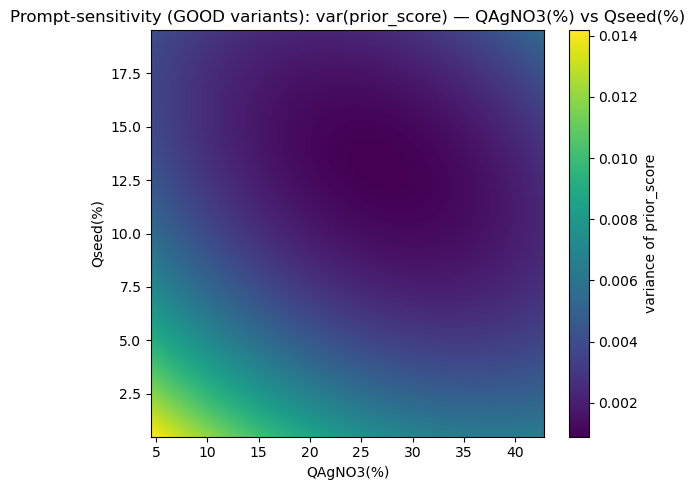

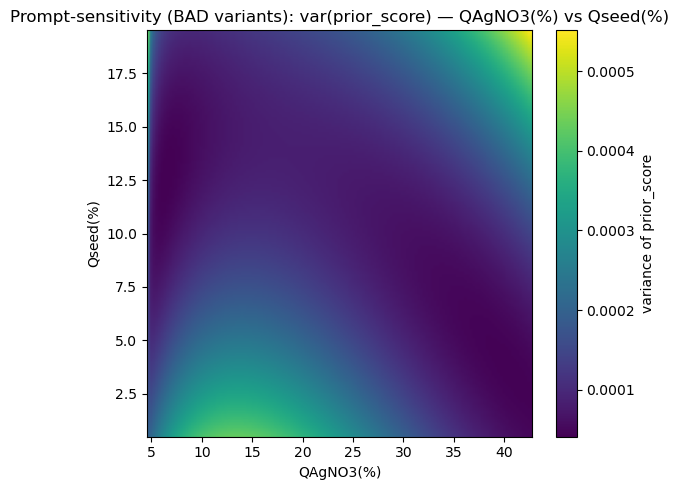

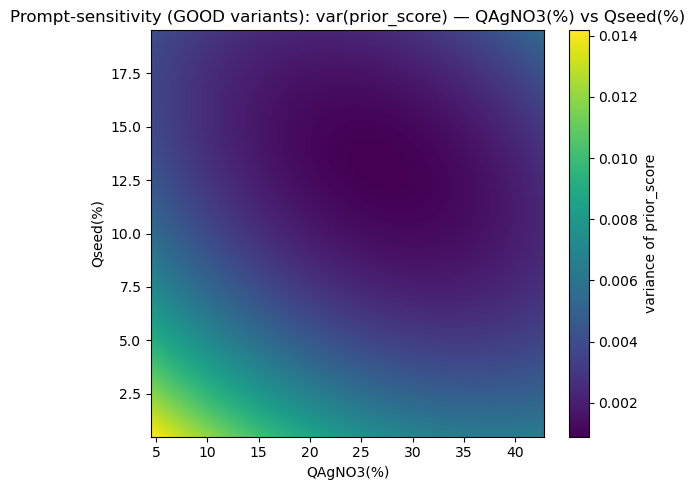

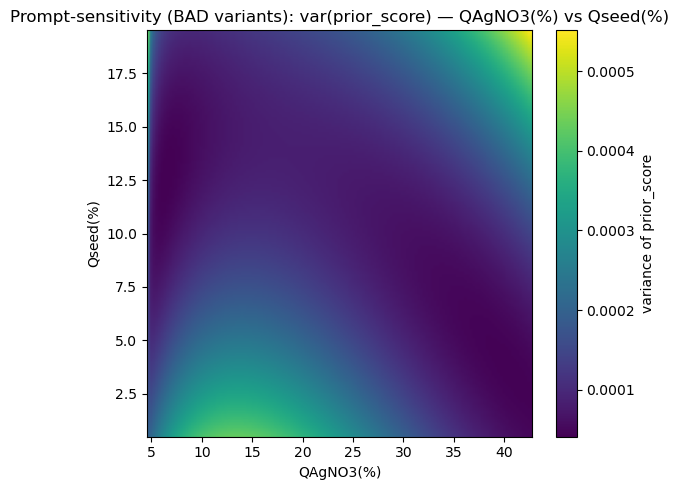

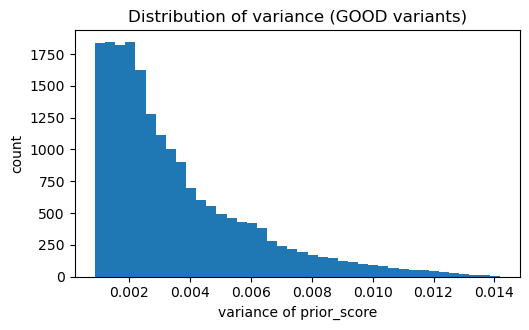

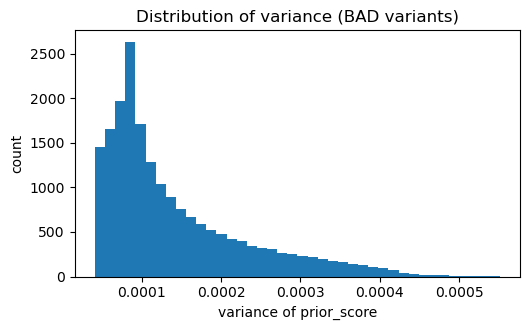

In [3]:
# B1 — Variance heatmaps + histograms
art = make_prompt_sensitivity_variance(
    data_csv="AgNP_dataset.csv",
    out_dir="agnp_prompt_sensitivity",
    var_pair=("QAgNO3(%)","Qseed(%)"),
    n_grid=140, n_variants=6, show=True
)

[LLM readout] Success, readout from
{'effects': {'QAgNO3(%)': {'effect': 'decrease', 'scale': 0.8, 'confidence': 0.9, 'range_hint': [1.0, 1.0]}, 'Qpva(%)': {'effect': 'nonmonotone-peak', 'scale': 0.7, 'confidence': 0.8, 'range_hint': [1.0, 1.0]}, 'Qtsc(%)': {'effect': 'decrease', 'scale': 0.6, 'confidence': 0.85, 'range_hint': [0.5, 1.0]}, 'Qseed(%)': {'effect': 'increase', 'scale': 0.75, 'confidence': 0.9, 'range_hint': [0.498851653, 1.0]}, 'Qtot(uL/min)': {'effect': 'increase-saturating', 'scale': 0.8, 'confidence': 0.85, 'range_hint': [1.0, 1.0]}}, 'interactions': [{'pair': ['QAgNO3(%)', 'Qseed(%)'], 'type': 'antagonism', 'confidence': 0.9}, {'pair': ['Qtsc(%)', 'QAgNO3(%)'], 'type': 'synergy', 'confidence': 0.8}], 'category_similarity': {}}
[LLM readout] Success, readout from
{'effects': {'QAgNO3(%)': {'effect': 'decrease', 'scale': 0.8, 'confidence': 0.9, 'range_hint': [1.0, 1.0]}, 'Qpva(%)': {'effect': 'nonmonotone-peak', 'scale': 0.7, 'confidence': 0.8, 'range_hint': [1.0, 1.0]}

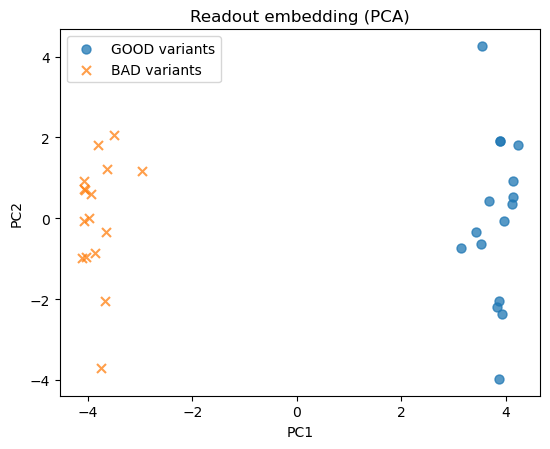

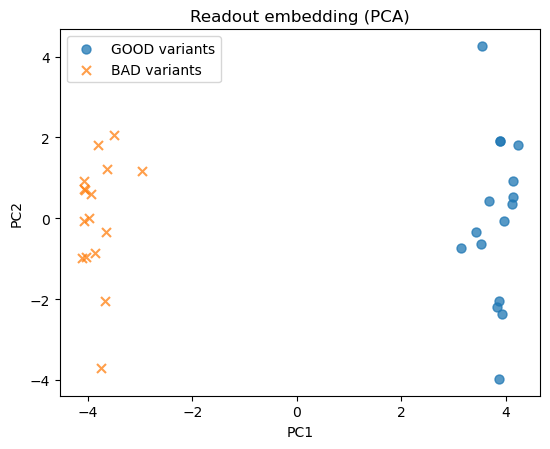

In [9]:
pca_art = make_readout_embedding_pca(
    data_csv="AgNP_dataset.csv",
    out_dir="agnp_prompt_sensitivity",
    n_variants=16, show=True
)

[LLM readout] Success, readout from
{'effects': {'QAgNO3(%)': {'effect': 'decrease', 'scale': 0.8, 'confidence': 0.9, 'range_hint': [1.0, 1.0]}, 'Qpva(%)': {'effect': 'nonmonotone-peak', 'scale': 0.7, 'confidence': 0.8, 'range_hint': [1.0, 1.0]}, 'Qtsc(%)': {'effect': 'decrease', 'scale': 0.6, 'confidence': 0.85, 'range_hint': [0.5, 1.0]}, 'Qseed(%)': {'effect': 'increase', 'scale': 0.75, 'confidence': 0.9, 'range_hint': [0.498851653, 1.0]}, 'Qtot(uL/min)': {'effect': 'increase-saturating', 'scale': 0.8, 'confidence': 0.85, 'range_hint': [1.0, 1.0]}}, 'interactions': [{'pair': ['QAgNO3(%)', 'Qseed(%)'], 'type': 'antagonism', 'confidence': 0.9}, {'pair': ['Qtsc(%)', 'QAgNO3(%)'], 'type': 'synergy', 'confidence': 0.8}], 'category_similarity': {}}


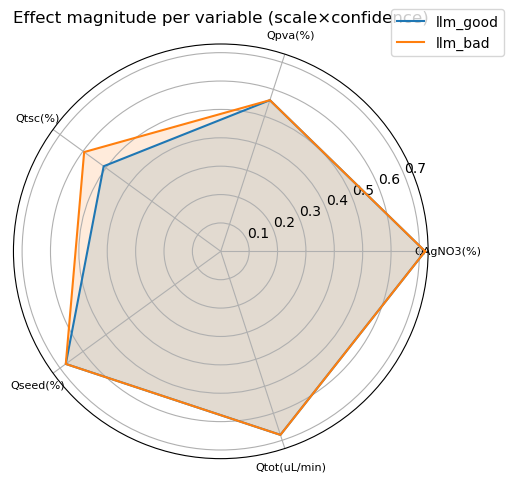

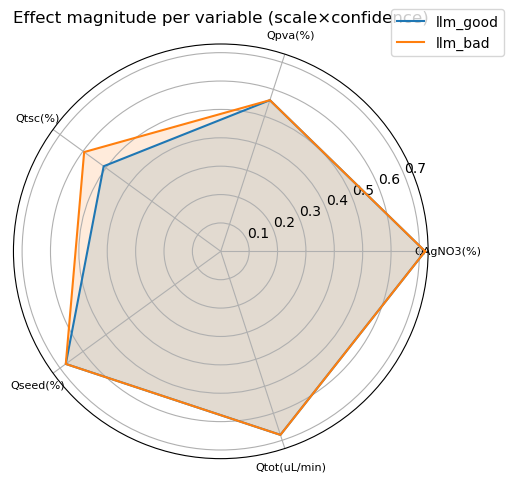

In [8]:
rad = make_radar_for_readouts(
    data_csv="AgNP_dataset.csv",
    out_dir="agnp_prompt_sensitivity",
    select=("llm_good","llm_bad"),
    show=True
)